# Lorenz System Particle Filter

A toy-model particle filter for the Lorenz System.

Authors: Hasan Khan

Meliza Lab, University of Virginia Psychology Department, 2017

In [28]:
import numpy as np
import math
import matplotlib
import matplotlib.pylab as plt
import mpld3
from numba import jit
# CDM: removed unused imports

%matplotlib inline

In [2]:
def progress_bar(N):
    """ Generates a standard, timed progress bar for an operation that takes N steps """
    import progressbar as pb
    return pb.ProgressBar(max_value=N, widgets= [" [", pb.Timer(), "] ", pb.Bar(), " (", pb.ETA(), ") "])


In [3]:
# CDM: comment functions, especially ones with short names
def euler ( f, dt, tfinal, x0):
    """Integrate f from 0 to tfinal using forward Euler
    
    f: system function (dX/dt)
    dt: time step for integration
    tfinal: final time
    x0: initial state
    
    """
    N = int(tfinal / dt)
    X = np.zeros((N, x0.size))
    state = x0.copy()
    X[0,:] = state
    for i in range (0, N):
        state = state + (f(state, i * dt) * dt)
        X[i,:] = state
    return X

In [109]:
@jit(nopython=True)
def f_lorenz(state, t):
    x, y, z, rho, sigma, beta = state  # unpack the augmented state vector
    return np.array((sigma * (y - x), x * (rho - z) - y, x * y - beta * z, 0, 0, 0))  # derivatives

In [88]:
@jit(nopython=True)
def lognormpdf(mu, x, sd):
    """Calculate log of the normal pdf"""
    var = sd**2
    denom = (2 * np.pi * var)**.5
    return ((- (x - mu)**2 / (2 * var))) - (np.log(denom))

In [89]:
def ess(weights):
    """Calculate effective sample size of an array of weights"""
    s1 = np.exp(weights).sum()
    s2 = np.exp(2 * weights).sum()  
    ess_D = np.exp(2 * np.log(s1) - np.log(s2))
    return ess_D

In [119]:
# CDM: split out the tasks into separate functions
# CDM: added docstring to this key function
# CDM: reordered some parameters and gave them default values

@jit(nopython=True)
def pf_step(p_states, t, dt):
    """Advance the particles one step based on system function
    
    Modifies the values in place.
    
    p_states: particle states (N, D)
    fn: the system function
    t: current time
    dt: step size
    
    """
    N, D = p_states.shape
    for i in range(N):
        p_states[i] += f_lorenz(p_states[i], t) * dt

        
def pf_noise(p_states, sd):
    """Add noise to particles
    
    p_states: particle states (N, D)
    sd: noise standard deviation (D)
    """
    N, D = p_states.shape
    p_states += np.random.normal(scale=sd, size=(N, D))
    
    
def pf_weights(p_states, p_weights, data, tol):
    """Update particle weights based on likelihood of data
    
    p_states: particle states (N, D)
    p_weights: particle weights (N,)
    data: observation (L,) [L <= D]
    tol: standard deviation for observation (L,)
    """
    N, D = p_states.shape
    L = data.size
    p_weights += lognormpdf(data, p_states[:, :L], tol).sum(axis=1)
    max_weight = max(p_weights) 
    p_weights -= max_weight 

    
def pf_resample(p_states, p_weights):
    """Resample particles based on weights. Returns a copy of p_states."""
    N, D = p_states.shape
    p = np.exp(p_weights)
    p /= np.sum(p)
    
    # CDM: not sure what this is for
    # p_states.append(0)
    # w = p_weights.tolist()
    # w.append(0.0)
        
    idx = np.random.choice(N, N, replace=True, p=p)
    p_states = p_states[idx, :]
    p_weights[:] = 0
    return p_states


In [120]:
def pf(data, dt, particles, weights=0, s_sd=0.05, o_sd=1.0, resamp_thresh=0.04):
    """Appply particle filter to data
    
    fn: system function
    data: observations (T, L)
    dt: time step (scalar)
    particles: initial particle states (N, D)
    weights: initial particle weights (scalar or (N,))
    s_sd: standard deviation for system noise (scalar or (D,)
    o_sd: standard deviations for observation noise (scalar or (L,))
    resamp_thresh: threshold effective sample size to resample (scalar)
    """
    ## INITIALIZING PARTICLE FILTER
    N, D = particles.shape
    T, L = data.shape
    assert L <= D, "Number of observations must be smaller than state vector"
    if np.isscalar(weights):
        weights = np.ones(N, dtype='d') * weights
    else:
        weights = np.asarray(weights, dtype='d')
        assert weights.shape == (N,), "Weights must be scalar or array with nparticles elements"
    if np.isscalar(s_sd):
        s_sd = np.ones(D, dtype='d') * s_sd
    else:
        s_sd = np.asarray(s_sd, dtype='d')
        assert s_sd.shape == (D,), "s_sd must be scalar or array with nstate elements"
    if np.isscalar(o_sd):
        o_sd = np.ones(L, dtype='d') * o_sd
    else:
        o_sd = np.asarray(o_sd, dtype='d')
        assert o_sd.shape == (L,), "o_sd must be scalar or array with nobs elements"
        

    chain = np.zeros((T, N, D), dtype='d')
    chainprob = np.zeros((T, N), dtype='d')
    resample_count = 0
    with progress_bar(T) as pb:
        for i in range(T):
            pf_step(particles, i * dt, dt)
            pf_noise(particles, s_sd)
            pf_weights(particles, weights, data[i], o_sd)
            curr_ess = ess(weights)
            if curr_ess < (resamp_thresh * N):
                resample_count += 1
                particles = pf_resample(particles, weights)
            chain[i, :, :] = particles
            chainprob[i, :] = weights
            pb.update(i)

    return chain, chainprob, resample_count
        

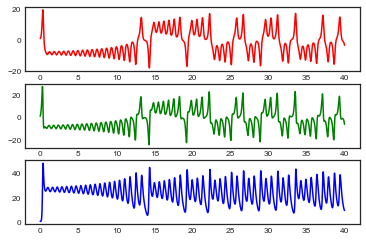

In [121]:
# PARTICLE FILTER SETTINGS AND PARAMETERS
state0 = [1.0, 1.0, 1.0, 28.0, 10.0, (8.0/3.0)]
dt = 0.001
T = 40.0

tp = np.arange(0.0, T, dt)
# generate "data"
data = euler(f_lorenz, dt, T, np.asarray(state0))
# CDM: not sure why you are saving each vector separately; you could do
# also it's best to avoid absolute paths in case someone else wants to run your code
np.save("lorenz_data.npy", data)

# CDM: a slightly cleaner version of the plotting code
fig = plt.figure(1)
for i, c in zip(range(3), ('r', 'g', 'b')):
    ax = plt.subplot(3, 1, i + 1)
    ax.plot(tp, data[:, i], c)

In [126]:
# DRIVER CELL. SET PARAMETERS AND CALL PARTICLE FILTER

nparticles = 250
starting_noise = 6.0
driving_noise = 0.05
tolerance = 1
start_pos = np.asarray([1.0, 1.0, 1.0, 22.0, 15.0, (8.0/1.0)])

# initialize particles in random ball around guess
pstates = start_pos + np.random.normal(scale=starting_noise, size=(nparticles, start_pos.size))

# assimilate some fraction of the data (CDM: speeds up debugging)
L = 3
T_assim = 20000
posteriors, weights, resample_count = pf(data[:T_assim,:L], dt, pstates, s_sd=driving_noise, o_sd=tolerance)
   

 [Elapsed Time: 0:00:07] |###################################| (Time: 0:00:07) 


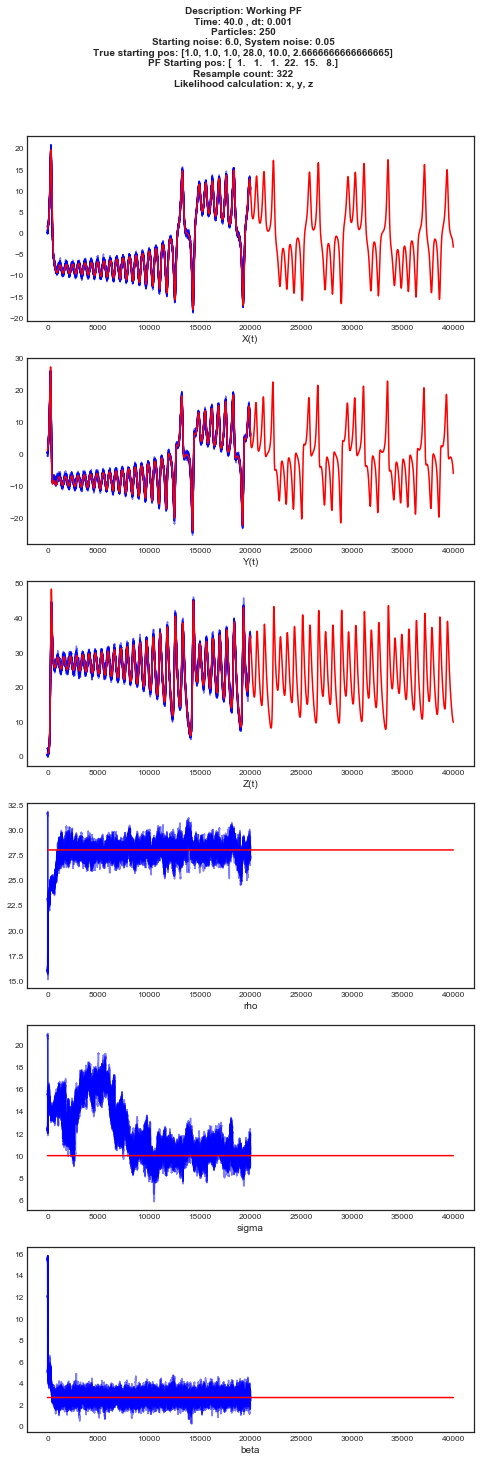

In [127]:
# PLOTTING SINGLE PARTICLE TRACES

import seaborn as sns
import mpld3

sns.set_style('white')
clr_plt = sns.color_palette('cubehelix',4)

fig = plt.figure(figsize=(8, 10))
fig.subplots_adjust(top=0.80, bottom = -1.0)

description = "Working PF"
true_start_pos = [1.0, 1.0, 1.0, 28.0, 10.0, (8.0/3.0)]

fig.suptitle('Description: ' + description + "\n" + 
             'Time: ' + str(T) + " , dt: " + str(dt) + "\n" + 
             'Particles: ' + str(nparticles) + "\n" +
             'Starting noise: ' + str(starting_noise) + ', System noise: ' + str(driving_noise) + "\n" +
             'True starting pos: ' + str(true_start_pos) + "\n" +
             'PF Starting pos: ' + str(start_pos) + "\n" +
             'Resample count: ' + str(resample_count) + "\n" +
             'Likelihood calculation: x, y, z'
             , fontsize=10, fontweight='bold')

# CDM: use loops to avoid repetitious code
labels = ("X(t)", "Y(t)", "Z(t)", "rho", "sigma", "beta")
for i, lbl in enumerate(labels):
    ax = fig.add_subplot(6, 1, i + 1)
    ax.set_xlabel(lbl)
    ax.plot(posteriors[:, :20, i], 'b', alpha = .5)
    ax.plot(data[:, i], 'r')



In [ ]:
# PLOTTING POSTERIOR DISTRIBUTIONS OF PARAMETERS

import pandas as pd 

clr_plt = sns.color_palette('cubehelix',4)
sns.set_style('darkgrid')


post_distr = pd.DataFrame(posteriors, columns = ["x", "y", "z", "rho", "beta", "sigma"])
post_distr = np.round(post_distr,2)


hists = post_distr.hist(bins=75,color=clr_plt[2],figsize=(16, 8),normed=True,grid='off')
#jointHist = np.histogram2d(posteriors[:,1], weights, bins = 10)

sns.despine()

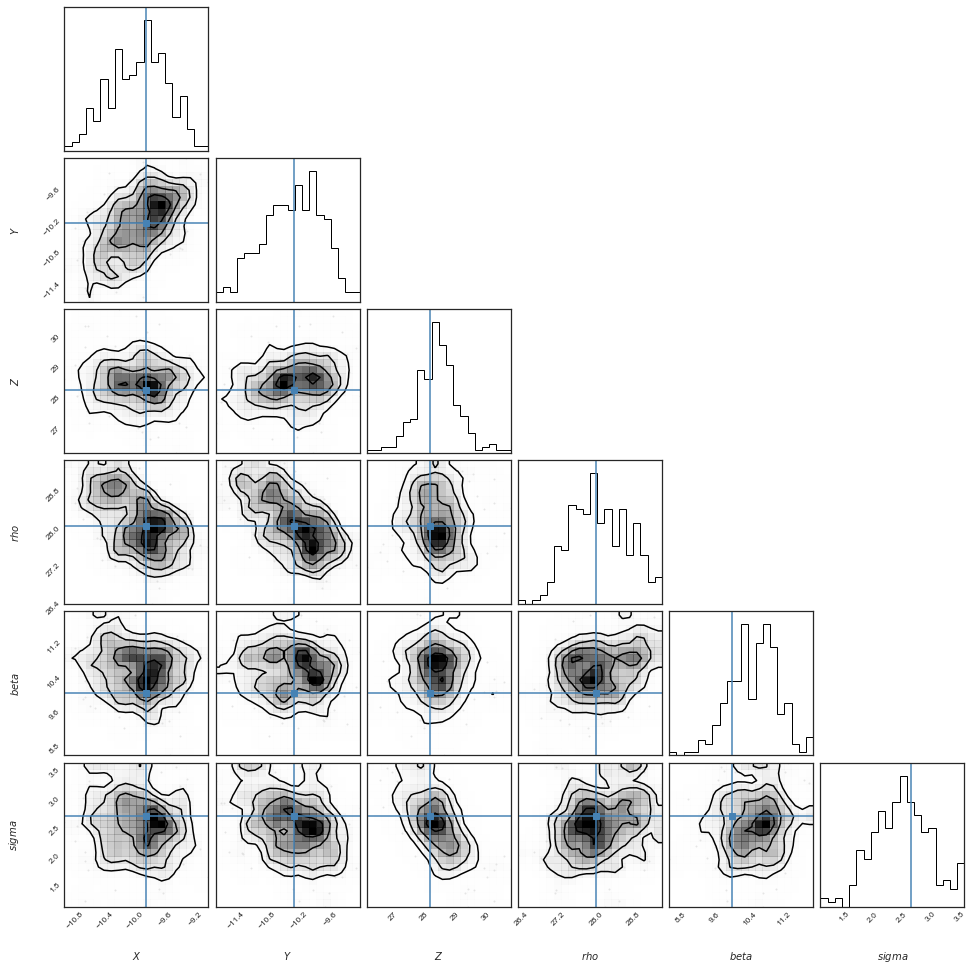

In [17]:
# DISPLAYING JOINT PDFS

import corner
last = posteriors[-1, :, :]
targets = data[T_assim]
fig = corner.corner(last, labels=["$X$", "$Y$", "$Z$", "$rho$", "$beta$", "$sigma$"], smooth = 1, truths=targets)
